# 4. Pastastore

In this notebook you will learn:
- what a pastastore is (within the context of the Pastas Python package).
- how observations series, stresses and models are stored in a pastastore.
- how to do bulk operations on pastastores.
- how to write and read a pastastores from a file.


In order to do bulk operations on time series models you can use a Pastastore. A Pastastore is an object that can contain observations, stresses and models at multiple observation points. The object has convenient methods to store time series data, create models, add stressmodels and summarize the results. This notebook gives a brief overview of the current possibilities.

In [1]:
# First perform the necessary imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import pastas as ps
import pastastore as pst
import hydropandas as hpd
from packaging import version
%matplotlib inline

In [2]:
ps.set_log_level("ERROR")
if version.parse(ps.__version__) < version.parse("0.16.0"):
    raise RuntimeError(
        f"this notebook is not working for pastas versions lower than 0.17.0, your version is {ps.__version__}"
    )

In [3]:
# create an empty Pastastore
conn = pst.DictConnector("pastastore")
store = pst.PastaStore(conn)
store

<PastaStore> pastastore: 
 - <DictConnector> 'pastastore': 0 oseries, 0 stresses, 0 models

## Observations
We can add observation (oseries) to the pastastore using the `store.add_oseries` method. Observations are added to `store.oseries`, which is a Pandas DataFrame. Metadata provided to `pst.add_oseries` is shown in the other columns of `store.oseries`.

In [4]:
# add the observations in all the files in the data-directory that end with _1.csv
datapath = r"data/nb4"
files = [x for x in os.listdir(datapath) if x.endswith("_1.csv")]
for file in files:
    fname = os.path.join(datapath, file)
    series = hpd.GroundwaterObs.from_dino(fname)
    store.add_oseries(
        series["stand_m_tov_nap"].dropna(),
        name=series.name,
        metadata={"x": series.x, "y": series.y},
    )

# show the contents of pr.oseries
store.oseries

INFO:hydropandas.io.dino:reading -> B32D0136001_1
INFO:hydropandas.io.dino:reading -> B33A0113001_1
INFO:hydropandas.io.dino:reading -> B58C0698001_1


c:\Users\oebbe\anaconda3\envs\paotm\Lib\site-packages\hydropandas\io\dino.py:155: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


,x,y,name
B32D0136-001,153344.0,457123.0,B32D0136-001
B33A0113-001,189780.0,471810.0,B33A0113-001
B58C0698-001,181600.0,359260.0,B58C0698-001


#### Exercise 1 <a name="ex1"></a>
Create a pastastore. Add the observations in the `data/nb4/ex1` directory to the model. Which measurements series has the lowest filter?

<a href="#ans1">Answer Exercise 1</a>

## Stresses
We can also add stresses to a pastastore using the `store.add_stress` method. We use the `kind=` argument to tell what kind of stress we add. We add the precipitation-series as `kind='prec'` and the evaporation-series as `kind='evap'`. Stresses are added to `store.stresses`, which is a Pandas DataFrame (just like `store.oseries`). Metadata provided to add_series is shown in the other columns of `store.stresses`.

In [5]:
# add evaporation
fname = os.path.join(datapath, "etmgeg_391.txt")
series = hpd.MeteoObs.from_knmi("EV24", fname=fname)
series.index = pd.to_datetime(series.index.date)
store.add_stress(
    series.squeeze(),
    name=series.name,
    kind="evap",
    metadata={"x": float(series.x), "y": float(series.y)},
)

# add precipitation
fname = os.path.join(datapath, "KNMI_Akkrum.txt")
series = hpd.MeteoObs.from_knmi("RD", fname=fname, fill_missing_obs=True)
series.index = pd.to_datetime(series.index.date)
store.add_stress(
    series.squeeze(),
    name=series.name,
    kind="prec",
    metadata={"x": float(series.x), "y": float(series.y)},
)

# show the stresses inside the pastastore
store.stresses

INFO:hydropandas.io.knmi:get KNMI data from file data/nb4\etmgeg_391.txt and meteo variable EV24


INFO:hydropandas.io.knmi:get KNMI data from file data/nb4\KNMI_Akkrum.txt and meteo variable RD


,x,y,kind,name
EV24_ARCEN,211170.177271,390120.746329,evap,EV24_ARCEN
RD_AKKRUM,184000.000000,563200.000000,prec,RD_AKKRUM


#### Exercise 2 <a name="ex2"></a>
Add the evaporation from De Bilt and the precipitation from Akkrum to the pastastore that you made in Exercise 1.

<a href="#ans2">Answer Exercise 2</a>

## Models
In a pastastore you can create time series models from the observations and add recharge. Models are added to `store.models`, which is a list with the model-names. The `add_recharge=True` adds a recharge stress to the model based on the precipitation- and evaporation-series closest to the location of the model's oseries.

The file that we used for precipitation did not contain any coordinates, which will therefore default to 0.0. The evaporation-file contains coordinates in epsg:4326, while our observation-files contain coordinates in epsg:28992. Right now we do not transform coordinates. So finding the closest precipitation- and evaporation-series will normally give wrong results. As we have only one precipitation and evaporation series however, this is not a problem.

In the code-section below, we make 11 models with recharge and solve them.

In [6]:
for name in store.oseries.index:
    ml = store.create_model(name, add_recharge=True)
    ml.solve(report=False)
    store.add_model(ml, overwrite=True)

# show the contents of pr.models
store.models

['B32D0136-001', 'B33A0113-001', 'B58C0698-001']

#### Exercise 3 <a name="ex3"></a>
Create models of the oseries in your pastastore from exercise 2 and solve them.

<a href="#ans3">Answer Exercise 3</a>

## Plot individual results
Take one of the models and plot the decomposition. As we can see, the precipitation series does not contain the first few years of the simulation. The start- and end-dates of the model (tmin and tmax) are solely determined by the observation-series.

array([<Axes: title={'center': 'observations vs. simulation'}>,
       <Axes: title={'center': 'recharge (RD_AKKRUM)'}>,
       <Axes: title={'center': 'recharge (EV24_ARCEN)'}>], dtype=object)

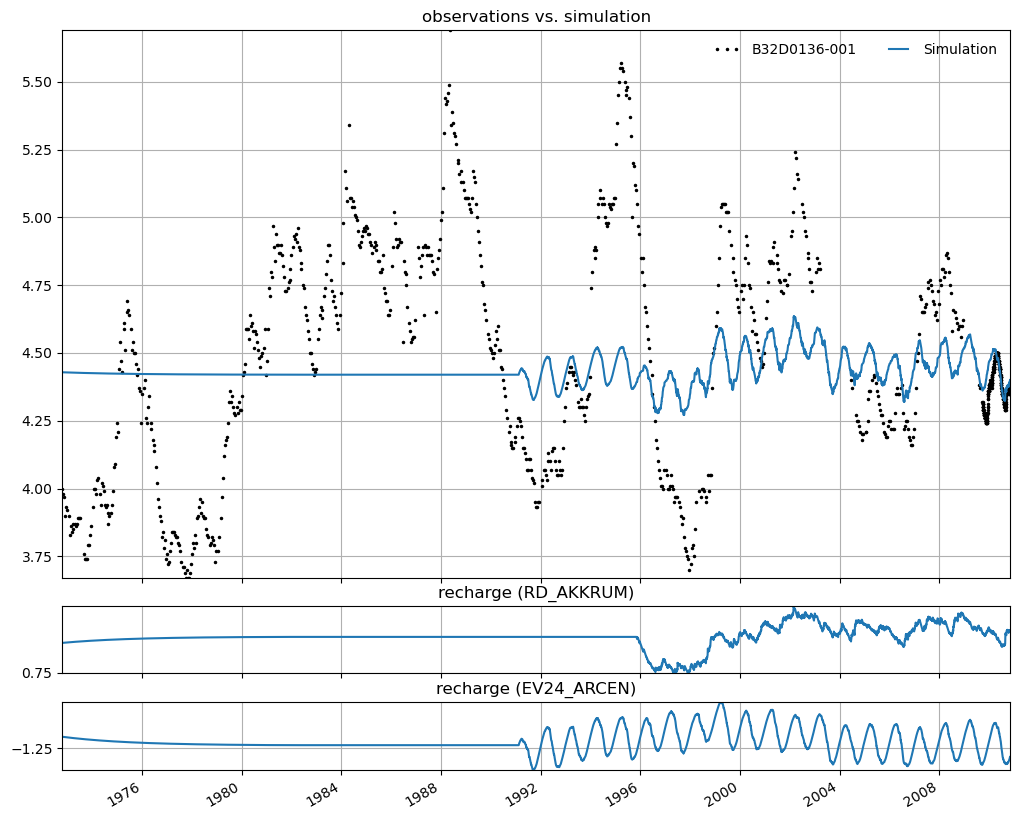

In [7]:
name = "B32D0136-001"
ml = store.get_models(name)
ml.plots.decomposition()

## Get some statistics / parameters of all models
Make a table with some statistics of the models

In [8]:
store.get_statistics(["evp", "aic"]).round(2)

,evp,aic
B32D0136-001,7.92,-8294.29
B33A0113-001,0.00,-24470.77
B58C0698-001,80.62,-1735.86


Make a table with some parameters of the models

In [9]:
store.get_parameters(["recharge_A", "constant_d", "noise_alpha"])

,recharge_A,constant_d,noise_alpha
B32D0136-001,382.023346,4.776180,1891.540855
B33A0113-001,0.000010,27.702487,4999.993307
B58C0698-001,477.004368,28.327435,65.303057


#### Exercise 4 <a name="ex4"></a>
Get the EVP from the models in your pastastore from exercise 3. What do you think?

<a href="#ans4">Answer Exercise 4</a>

#### Exercise 5 <a name="ex5"></a>

Improve the models in your pastastore from exercise 4 by:
- replacing the precipitation from Akkrum with measurements from IJsselstein. Use this website to obtain the data https://www.knmi.nl/nederland-nu/klimatologie/monv/reeksen. 
- replacing the evaporation from De Bilt with the evaporation from Arcen using this website https://www.knmi.nl/nederland-nu/klimatologie/daggegevens. 

Does this improve the EVP? Plot the results of model B52D0502_1, what do you see?

<a href="#ans5">Answer Exercise 5</a>

#### Exercise 6 <a name="ex6"></a>
There are no evaporation measurements at Arcen before 1991. Change the calibration period of the models using tmin in such a way that a more realistic model is created.

<a href="#ans6">Answer Exercise 6</a>

#### Exercise 7 <a name="ex7"></a>
Add a step trend to the models in january 2010. Solve the models and explore the results. What happens?

<a href="#ans7">Answer Exercise 7</a>

## Saving and reading pastastores
We can save an entire pastastore, with all its series and models, to a file.

In [10]:
store.to_zip("pastasstore.zip", overwrite=True)

c:\Users\oebbe\anaconda3\envs\paotm\Lib\site-packages\pastastore\store.py:772: UserWarning: Overwriting file 'pastasstore.zip'


models: 100%|██████████| 3/3 [00:00<00:00, 78.61it/s]


Later we can reload this pastastore again

In [11]:
conn = pst.DictConnector("pastastore")
pst.PastaStore.from_zip("pastasstore.zip", conn)

Reading zip: 100%|██████████| 8/8 [00:00<00:00, 50.83it/s]


<PastaStore> pastastore: 
 - <DictConnector> 'pastastore': 3 oseries, 2 stresses, 3 models

Test if everything went ok by plotting the decomposition of B32D0136-001 again. This figure is exactly the same as before.

array([<Axes: title={'center': 'observations vs. simulation'}>,
       <Axes: title={'center': 'recharge (RD_AKKRUM)'}>,
       <Axes: title={'center': 'recharge (EV24_ARCEN)'}>], dtype=object)

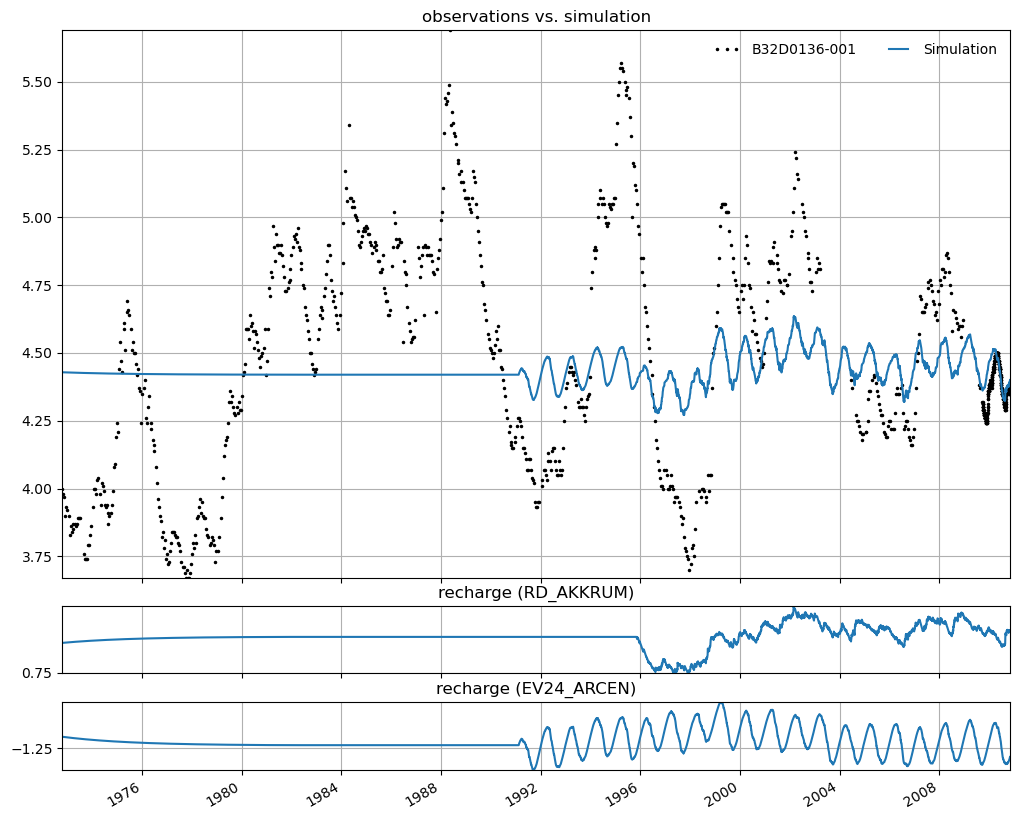

In [12]:
name = "B32D0136-001"
ml = store.get_models(name)
ml.plots.decomposition()


## Answers

#### <a href="#ex1">Answer exercise 1</a> <a name="ans1"></a>

Measurement point B52D0192_2 has the lowest filter. This can be seen in the column `Onderkant filter (cm t.o.v. NAP)` from the dataframe: `pr_q.oseries`. This is a hard question if you don't know Dutch (sorry!).

In [13]:
# add the observations in all the files in the data-directory that end with _1.csv
conn2 = pst.DictConnector("data_nb4")
store2 = pst.PastaStore(conn2)

datapath2 = r"data/nb4/ex1"
files = [x for x in os.listdir(datapath2) if x.endswith("_1.csv")]
for file in files:
    fname = os.path.join(datapath2, file)
    series = hpd.GroundwaterObs.from_dino(fname)
    store2.add_oseries(
        series["stand_m_tov_nap"],
        name=series.name,
        metadata={"x": series.x, "y": series.y},
    )

# show the contents of pr.oseries
store2.oseries

INFO:hydropandas.io.dino:reading -> B52C2089001_1


INFO:hydropandas.io.dino:reading -> B52D0192001_1
INFO:hydropandas.io.dino:reading -> B52D0192002_1
INFO:hydropandas.io.dino:reading -> B52D0201001_1
INFO:hydropandas.io.dino:reading -> B52D0201002_1
INFO:hydropandas.io.dino:reading -> B52D0495001_1
INFO:hydropandas.io.dino:reading -> B52D0495002_1
INFO:hydropandas.io.dino:reading -> B52D0502001_1


,x,y,name
B52C2089-001,188619.0,383753.0,B52C2089-001
B52D0192-001,190715.0,383280.0,B52D0192-001
B52D0192-002,190715.0,383280.0,B52D0192-002
B52D0201-001,193221.0,378361.0,B52D0201-001
B52D0201-002,193221.0,378361.0,B52D0201-002
B52D0495-001,192798.0,378240.0,B52D0495-001
B52D0495-002,192798.0,378240.0,B52D0495-002
B52D0502-001,192320.0,382590.0,B52D0502-001


#### <a href="#ex2">Answer exercise 2</a> <a name="ans2"></a>

In [14]:
datapath2 = r"data/nb4"

# add evaporation
fname = os.path.join(datapath, "etmgeg_391.txt")
series = hpd.MeteoObs.from_knmi("EV24", fname=fname)
series.index = pd.to_datetime(series.index.date)
store2.add_stress(
    series,
    name=series.name,
    kind="evap",
    metadata={"x": float(series.x), "y": float(series.y)},
)

# add precipitation
fname = os.path.join(datapath, "KNMI_Akkrum.txt")
series = hpd.MeteoObs.from_knmi("RD", fname=fname)
series.index = pd.to_datetime(series.index.date)
store2.add_stress(
    series,
    name=series.name,
    kind="prec",
    metadata={"x": float(series.x), "y": float(series.y)},
)

# show the contents of pr.stresses
store2.stresses

INFO:hydropandas.io.knmi:get KNMI data from file data/nb4\etmgeg_391.txt and meteo variable EV24
INFO:hydropandas.io.knmi:get KNMI data from file data/nb4\KNMI_Akkrum.txt and meteo variable RD


,x,y,kind,name
EV24_ARCEN,211170.177271,390120.746329,evap,EV24_ARCEN
RD_AKKRUM,184000.000000,563200.000000,prec,RD_AKKRUM


#### <a href="#ex3">Answer exercise 3</a> <a name="ans3"></a>

In [15]:
store2.oseries

,x,y,name
B52C2089-001,188619.0,383753.0,B52C2089-001
B52D0192-001,190715.0,383280.0,B52D0192-001
B52D0192-002,190715.0,383280.0,B52D0192-002
B52D0201-001,193221.0,378361.0,B52D0201-001
B52D0201-002,193221.0,378361.0,B52D0201-002
B52D0495-001,192798.0,378240.0,B52D0495-001
B52D0495-002,192798.0,378240.0,B52D0495-002
B52D0502-001,192320.0,382590.0,B52D0502-001


In [16]:
# alternative with a for-loop
for name in store2.oseries.index:
    ml = store2.create_model(name, add_recharge=True)
    ml.solve(report=False)
    store2.add_model(ml)

#### <a href="#ex4">Answer exercise 4</a> <a name="ans4"></a>

See the explained variance (evp) in the cell below. The evp is rather low. In general people use an evp value of more than 70-80% for a reasonable fit.

In [17]:
store2.get_statistics(["evp"])

B52C2089-001    39.584527
B52D0192-001    26.722604
B52D0192-002    51.281118
B52D0201-001    59.397731
B52D0201-002    65.933407
B52D0495-001    17.139517
B52D0495-002    36.735010
B52D0502-001    48.915867
Name: evp, dtype: float64

#### <a href="#ex5">Answer exercise 5</a> <a name="ans5"></a>

The evaporation time series of IJsselstein has no values before 1991 and therefore the model of B52D0502_1 and others have a poor fit/low evp. 

INFO:hydropandas.io.knmi:get KNMI data from file data/nb4\neerslaggeg_IJSSELSTEYN-L_913.txt and meteo variable RD


B52C2089-001    62.689328
B52D0192-001    40.637630
B52D0192-002    70.628965
B52D0201-001    68.437513
B52D0201-002    85.322372
B52D0495-001    35.637202
B52D0495-002    37.571056
B52D0502-001    66.042950
Name: evp, dtype: float64


array([<Axes: title={'center': 'observations vs. simulation'}>,
       <Axes: title={'center': 'recharge (RD_IJSSELSTEYN-L)'}>,
       <Axes: title={'center': 'recharge (EV24_ARCEN)'}>], dtype=object)

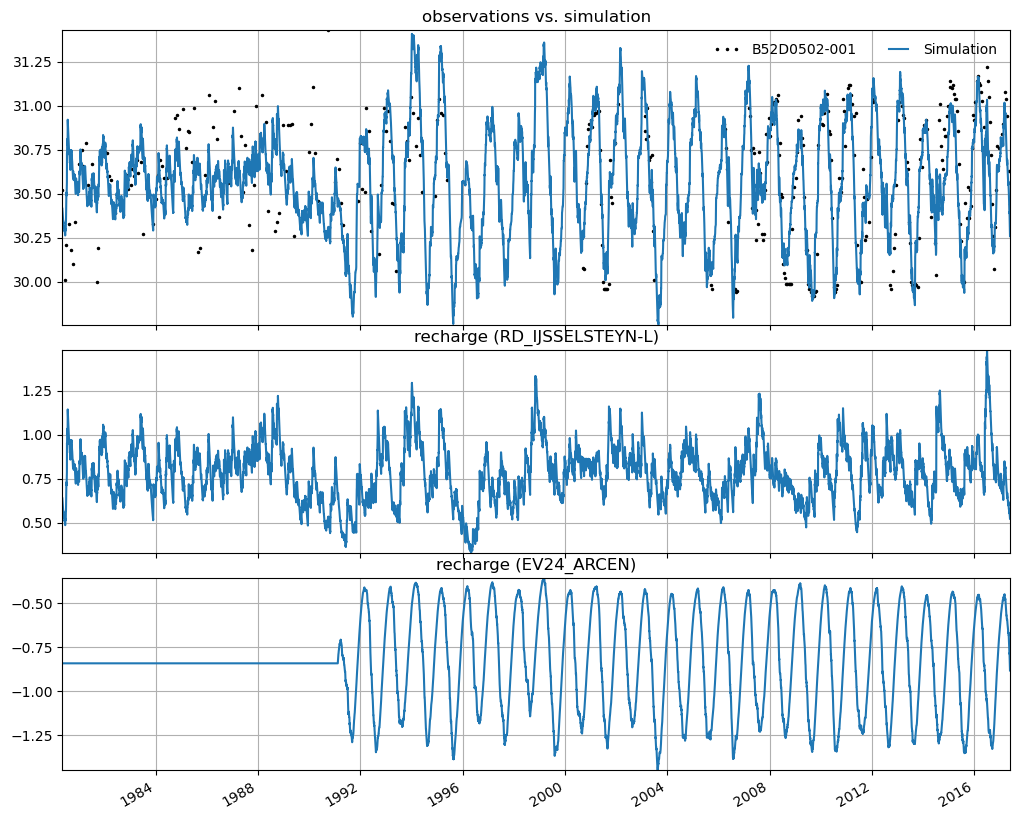

In [18]:
# add precipitation
fname = os.path.join(datapath, "neerslaggeg_IJSSELSTEYN-L_913.txt")
series = hpd.MeteoObs.from_knmi("RD", fname=fname)
series.index = pd.to_datetime(series.index.date)
store2.add_stress(
    series,
    name=series.name,
    kind="prec",
    metadata={"x": float(series.x), "y": float(series.y)},
)


# delete existing stresses
store2.del_stress("RD_AKKRUM")

# create and solve the models
for name in store2.oseries.index:
    ml = store2.create_model(name, add_recharge=True)
    ml.solve(report=False)
    store2.add_model(ml, overwrite=True)


# get the statistics
print(store2.get_statistics(["evp"]))

# results of individual model
name = "B52D0502-001"
ml = store2.get_models(name)
ml.plots.decomposition()

#### <a href="#ex6">Answer exercise 6</a> <a name="ans6"></a>

B52C2089-001    62.689328
B52D0192-001    52.187893
B52D0192-002    79.810045
B52D0201-001    68.437513
B52D0201-002    85.322372
B52D0495-001    35.637202
B52D0495-002    37.571056
B52D0502-001    79.537071
Name: evp, dtype: float64


array([<Axes: title={'center': 'observations vs. simulation'}>,
       <Axes: title={'center': 'recharge (RD_IJSSELSTEYN-L)'}>,
       <Axes: title={'center': 'recharge (EV24_ARCEN)'}>], dtype=object)

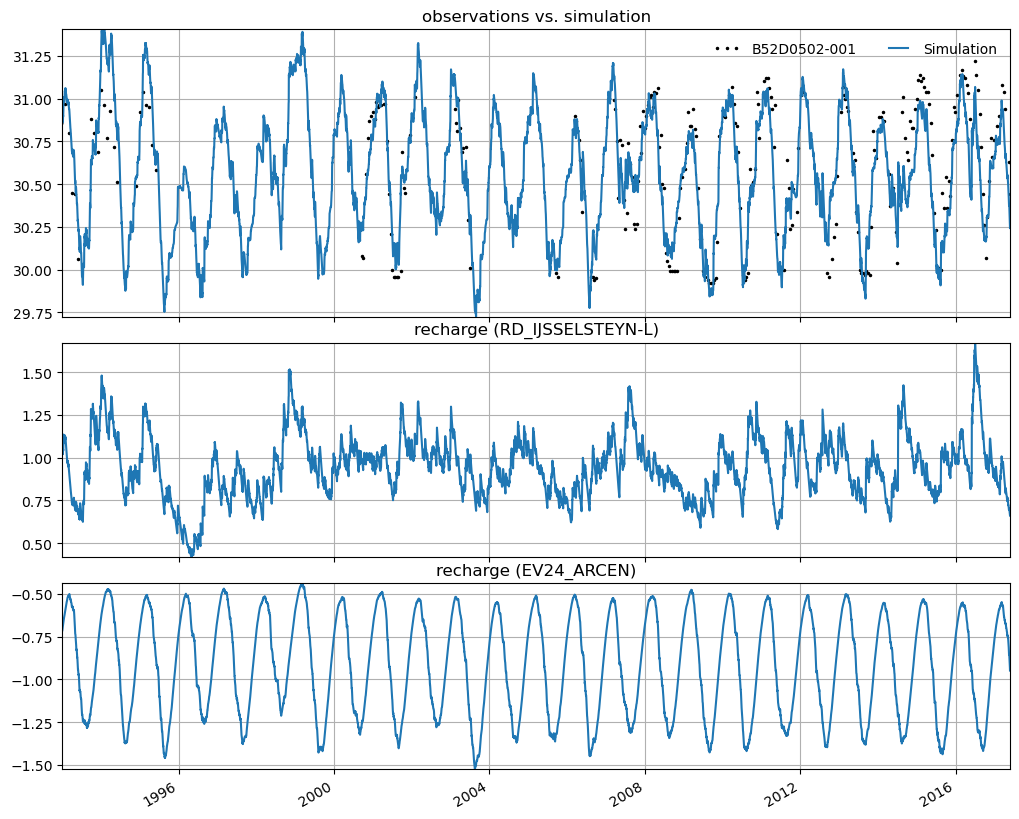

In [19]:
for name in store2.oseries.index:
    ml = store2.create_model(name, add_recharge=True)
    ml.solve(tmin="1993", report=False)
    store2.add_model(ml, overwrite=True)

print(store2.get_statistics(["evp"]))

# results of individual model
name = "B52D0502-001"
ml = store2.get_models(name)
ml.plots.decomposition()

#### <a href="#ex7">Answer exercise 7</a> <a name="ans7"></a>

There seems to be little effect of the steptrend on the model results

B52C2089-001    66.333082
B52D0192-001    52.187881
B52D0192-002    80.044095
B52D0201-001    68.682805
B52D0201-002    85.322357
B52D0495-001    49.976441
B52D0495-002    37.582638
B52D0502-001    82.597739
Name: evp, dtype: float64


array([<Axes: title={'center': 'observations vs. simulation'}>,
       <Axes: title={'center': 'recharge (RD_IJSSELSTEYN-L)'}>,
       <Axes: title={'center': 'recharge (EV24_ARCEN)'}>,
       <Axes: title={'center': 'step'}>], dtype=object)

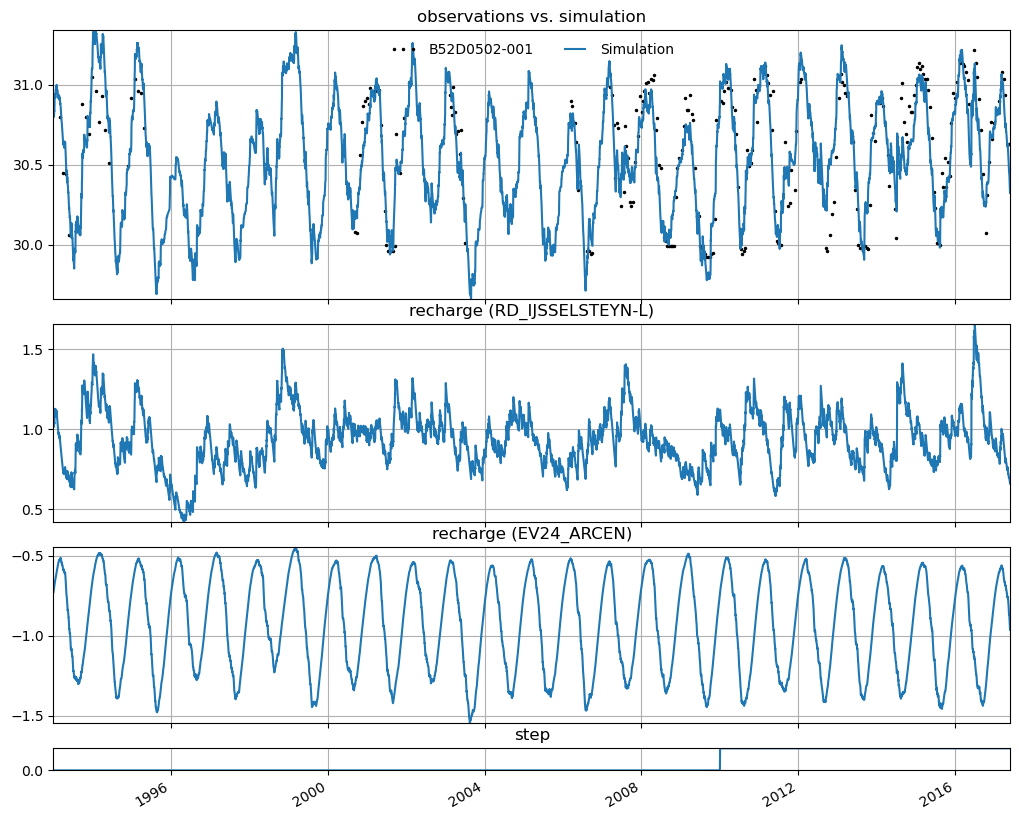

In [20]:
sm = ps.stressmodels.StepModel("2010", name="step", up=True)
sm2 = ps.stressmodels.StepModel("2013", name="step2", up=True)

for name in store2.oseries.index:
    ml = store2.create_model(name, add_recharge=True)
    ml.add_stressmodel(sm)
    # ml.add_stressmodel(sm2)
    ml.solve(tmin="1993", report=False)
    store2.add_model(ml, overwrite=True)

print(store2.get_statistics(["evp"]))

# results of individual model
name = "B52D0502-001"
ml = store2.get_models(name)
ml.plots.decomposition()